In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load Dataset
df1=pd.read_csv('./FishWeight.csv')
df1.head()

,Length1,Length2,Length3,Height,Width,Weight
0,23.2,25.4,30.0,11.5200,4.0200,242.0
1,24.0,26.3,31.2,12.4800,4.3056,290.0
2,23.9,26.5,31.1,12.3778,4.6961,340.0
3,26.3,29.0,33.5,12.7300,4.4555,363.0
4,26.5,29.0,34.0,12.4440,5.1340,430.0


In [3]:
df1.shape

(159, 6)

In [4]:
#Create Profile Report

#Importing package
import ydata_profiling as pp
from IPython.display import IFrame

df1Report = pp.ProfileReport(df1)
df1Report.to_file('df1Report.html')
display(IFrame('df1Report.html', width=900, height=350))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [55]:
#Key Statistics
dataset = df1.describe()
dataset

,Length1,Length2,Length3,Height,Width,Weight
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,26.247170,28.415723,31.227044,8.970994,4.417486,398.326415
std,9.996441,10.716328,11.610246,4.286208,1.685804,357.978317
min,7.500000,8.400000,8.800000,1.728400,1.047600,0.000000
25%,19.050000,21.000000,23.150000,5.944800,3.385650,120.000000
50%,25.200000,27.300000,29.400000,7.786000,4.248500,273.000000
75%,32.700000,35.500000,39.650000,12.365900,5.584500,650.000000
max,59.000000,63.400000,68.000000,18.957000,8.142000,1650.000000


In [5]:
#Tukey Method

# Import required libraries
from collections import Counter

# Outlier detection 
def detect_outliers(df,n,features):
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# List of Outliers
Outliers_to_drop = detect_outliers(df1.drop('Weight',axis=1),0,list(df1.drop('Weight',axis=1)))
df1.drop('Weight',axis=1).loc[Outliers_to_drop]

,Length1,Length2,Length3,Height,Width
142,56.0,60.0,64.0,9.600,6.144
143,56.0,60.0,64.0,9.600,6.144
144,59.0,63.4,68.0,10.812,7.480


In [6]:
#Create New Dataset without Outliers
good_data = df1.drop(df1.index[Outliers_to_drop]).reset_index(drop = True)
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Length1  156 non-null    float64
 1   Length2  156 non-null    float64
 2   Length3  156 non-null    float64
 3   Height   156 non-null    float64
 4   Width    156 non-null    float64
 5   Weight   156 non-null    float64
dtypes: float64(6)
memory usage: 7.4 KB


In [7]:
#Create Standard Model

#Define x and y variable
x = good_data.drop('Weight',axis=1).to_numpy()
y = good_data['Weight'].to_numpy()

#Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

In [8]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_lm = Pipeline([('scl', StandardScaler()),
                    ('clf', LinearRegression())])
pipeline.insert(0,pipe_lm)

pipe_lasso= Pipeline([('scl', StandardScaler()),
                     ('clf', Lasso(random_state=100))])
pipeline.insert(1,pipe_lasso)

pipe_ridge= Pipeline([('scl', StandardScaler()),
                     ('clf', Ridge(random_state=100))])
pipeline.insert(2,pipe_ridge)

pipe_elas= Pipeline([('scl', StandardScaler()),
                     ('clf', ElasticNet(random_state=100))])
pipeline.insert(3,pipe_elas)

# Set grid search params 

modelpara =[]

param_gridlm = {}
modelpara.insert(0,param_gridlm)

param_gridlasso = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20],
                  'clf__tol':[1e-1, 1, 5, 10, 20, 50, 100]}
modelpara.insert(1,param_gridlasso)

param_gridridge = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20],
                  'clf__tol':[1e-1, 1, 5, 10, 20, 50, 100]}
modelpara.insert(2,param_gridridge)

param_gridelas = {'clf__alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1e-1, 1, 5, 10, 20],
                 'clf__tol':[1e-1, 1, 5, 10, 20, 50, 100]}
modelpara.insert(3,param_gridelas)

In [9]:
#Create Learning Curves

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring = 'neg_root_mean_squared_error',
                                                            cv=10,random_state=100)
    
    train_mean = np.sqrt(np.mean(-train_scores, axis=1))
    train_std = np.sqrt(np.std(-train_scores, axis=1))
    test_mean = np.sqrt(np.mean(-test_scores, axis=1))
    test_std = np.sqrt(np.std(-test_scores, axis=1))
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('RMSE')
    plt.legend(loc='best')
    plt.ylim([-1,10])
    plt.show()

Learning Curve - LM


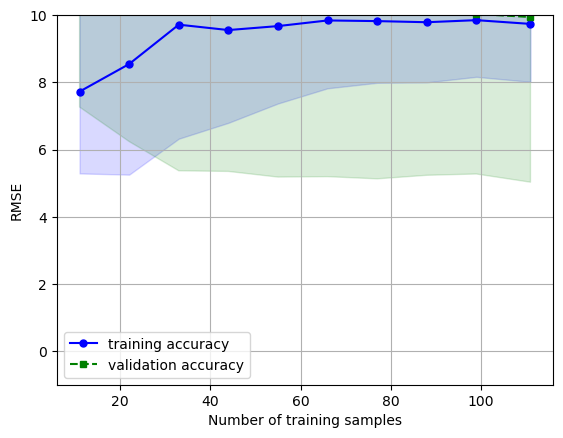

Learning Curve - Lasso


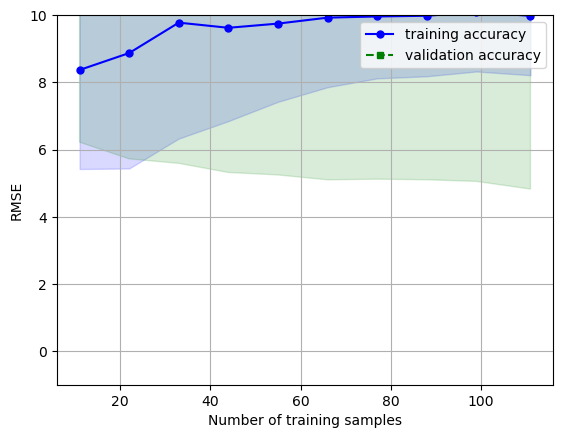

Learning Curve - Ridge


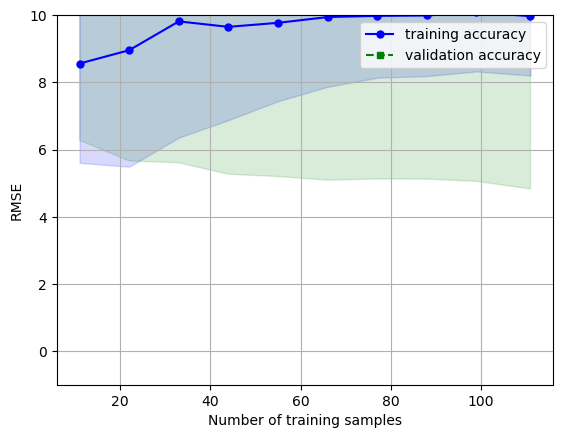

Learning Curve - ElasticNet


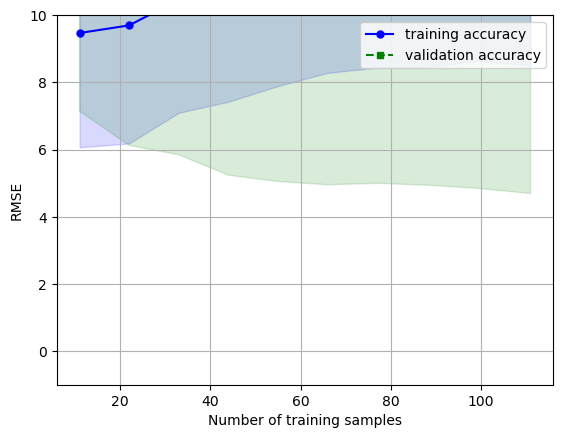

In [10]:
#Plot Learning Curve

print('Learning Curve - LM')
plot_learning_curves(pipe_lm)
print('Learning Curve - Lasso')
plot_learning_curves(pipe_lasso)
print('Learning Curve - Ridge')
plot_learning_curves(pipe_ridge)
print('Learning Curve - ElasticNet')
plot_learning_curves(pipe_elas)

Model Evaluation - RMSE
LinearRegression 9.93
Lasso 10.12
Ridge 10.11
ElasticNet 10.36




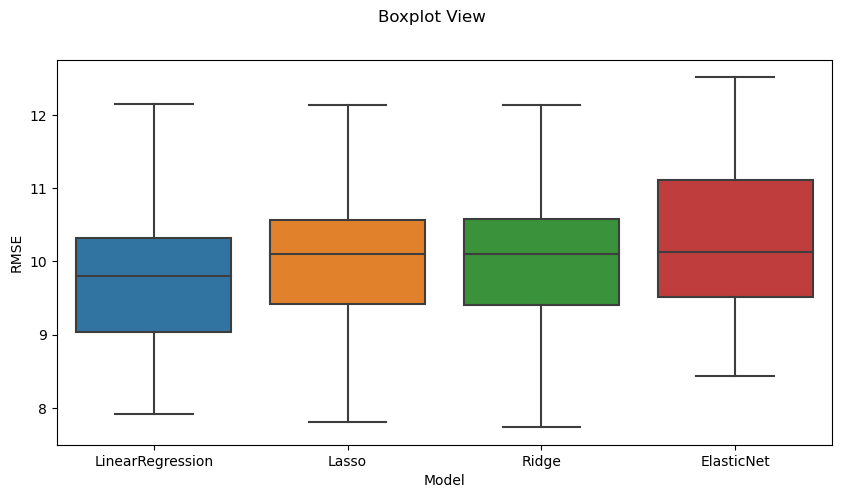

In [11]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('LinearRegression',pipe_lm))
models.append(('Lasso',pipe_lasso))
models.append(('Ridge',pipe_ridge))
models.append(('ElasticNet',pipe_elas))
  
#Model Evaluation
results =[]
names=[]
scoring ='neg_root_mean_squared_error'
print('Model Evaluation - RMSE')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train,y_train,cv=rkf,scoring=scoring)
    results.append(np.sqrt(-cv_results))
    names.append(name)
    print('{} {:.2f}'.format(name,np.sqrt(-cv_results.mean())))
print('\n')

#Boxplot View
fig = plt.figure(figsize=(10,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.show()

In [12]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn import metrics

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='neg_root_mean_squared_error')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
   
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    print('\nBest Parameters:',bestpara)
    
    #Test data accuracy of model with best params    
    print('\nIntercept: {:.2f}'.format(float(gs_clf.best_estimator_.named_steps['clf'].intercept_)))
    print('\nModel coefficients: ')   
    for name, score in zip(list(good_data.drop('Weight',axis=1)),
                           gs_clf.best_estimator_.named_steps['clf'].coef_):
         print(name, round(score,2)) 
    
    #Print R2
    print('\nR2: {:0.2f}'.format(metrics.r2_score(y_test,y_pred)))
    adjusted_r_squared2 = 1-(1-metrics.r2_score(y_test,y_pred))*(len(y)-1)/(len(y)-x.shape[1]-1)
    print('Adj_R2: {:0.2f}'.format(adjusted_r_squared2))        
      
    #Print MSE and RMSE
    print('\nMean Absolute Error: {:.2f}'.format(metrics.mean_absolute_error(y_test, y_pred)))  
    print('Mean Squared Error: {:.2f}'.format(metrics.mean_squared_error(y_test, y_pred)))  
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))) 

In [13]:
#Run Models
for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: LinearRegression()

Best Parameters: {}

Intercept: 355.32

Model coefficients: 
Length1 1125.77
Length2 -725.26
Length3 -294.06
Height 131.79
Width 88.1

R2: 0.90
Adj_R2: 0.89

Mean Absolute Error: 96.65
Mean Squared Error: 13526.90
Root Mean Squared Error: 116.31

Optimized Model

Model Name: Lasso(random_state=100)

Best Parameters: {'clf__alpha': 10, 'clf__tol': 0.1}

Intercept: 355.32

Model coefficients: 
Length1 186.49
Length2 0.6
Length3 1.92
Height 90.46
Width 30.57

R2: 0.87
Adj_R2: 0.87

Mean Absolute Error: 105.93
Mean Squared Error: 16321.08
Root Mean Squared Error: 127.75

Optimized Model

Model Name: Ridge(random_state=100)

Best Parameters: {'clf__alpha': 0.01, 'clf__tol': 0.1}

Intercept: 355.32

Model coefficients: 
Length1 954.88
Length2 -547.49
Length3 -297.24
Height 128.11
Width 86.62

R2: 0.90
Adj_R2: 0.89

Mean Absolute Error: 96.46
Mean Squared Error: 13321.32
Root Mean Squared Error: 115.42

Optimized Model

Model Name: ElasticNet(